In [88]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
from matplotlib import rcParams
import seaborn as sns
from textwrap import wrap
from tqdm import tqdm
import pandas as pd
import re
import math
import gc
import json

In [89]:
def read_tensors_aux(dir, pt_name_predicate=None):
    """ recursively read tensors from a directory """
    if pt_name_predicate is None:
        pt_name_predicate = lambda x, y: True
    tensors = {}
    for path in os.listdir(dir):
        if path.endswith('.pt'):
            key = path[:-3]
            if pt_name_predicate is None or pt_name_predicate(key, dir):
                try:
                    tensors[key] = torch.load(os.path.join(dir, path))
                except Exception as e:
                    print(f"Error loading {path}: {e}")
        elif os.path.isdir(os.path.join(dir, path)):
            key = path.split('_')[1] if path.startswith('timestep_') else path 
            tensors[key] = read_tensors_aux(os.path.join(dir, path), pt_name_predicate)
        else:
            print(f"Skipping {path}, not a tensor or directory")
    return tensors

In [118]:
dirname = 'outputs/grpo_mock_scorer_cat03'
with open(f'{dirname}/training_log_group.csv', 'r') as f:
    logs = f.read().replace("'", '"').replace('nan', 'null').splitlines()
    logs = [json.loads(line) for line in logs if line.strip()]

In [119]:
logs[0].keys()

dict_keys(['epoch', 't', 'prompt_idx', 'seed_idx', 'ref_reward', 'rewards', 'advantages', 'normalized_advantages', 'logps', 'loss'])

In [120]:
data = []
for log in logs:
    for key in ['rewards', 'advantages', 'normalized_advantages', 'logps']:
        for g in range(G):
            data.append({
                'epoch': log['epoch'],
                't': log['t'],
                'prompt_idx': log['prompt_idx'],
                'seed_idx': log['seed_idx'],
                'G_idx': g,
                'metric': key,
                'value': log[key][g]
            })
    data.append({
        'epoch': log['epoch'],
        't': log['t'],
        'prompt_idx': log['prompt_idx'],
        'seed_idx': log['seed_idx'],
        'G_idx': None,
        'metric': 'loss',
        'value': log['loss']
    })
    data.append({
        'epoch': log['epoch'],
        't': log['t'],
        'prompt_idx': log['prompt_idx'],
        'seed_idx': log['seed_idx'],
        'G_idx': None,
        'metric': 'rewards',
        'value': log['ref_reward']
    })

df = pd.DataFrame(data)

In [121]:
metrics = df['metric'].unique()
n_metrics = len(metrics)
n_epochs = df['epoch'].nunique()
G = df['G_idx'].nunique() - 1  # exclude None

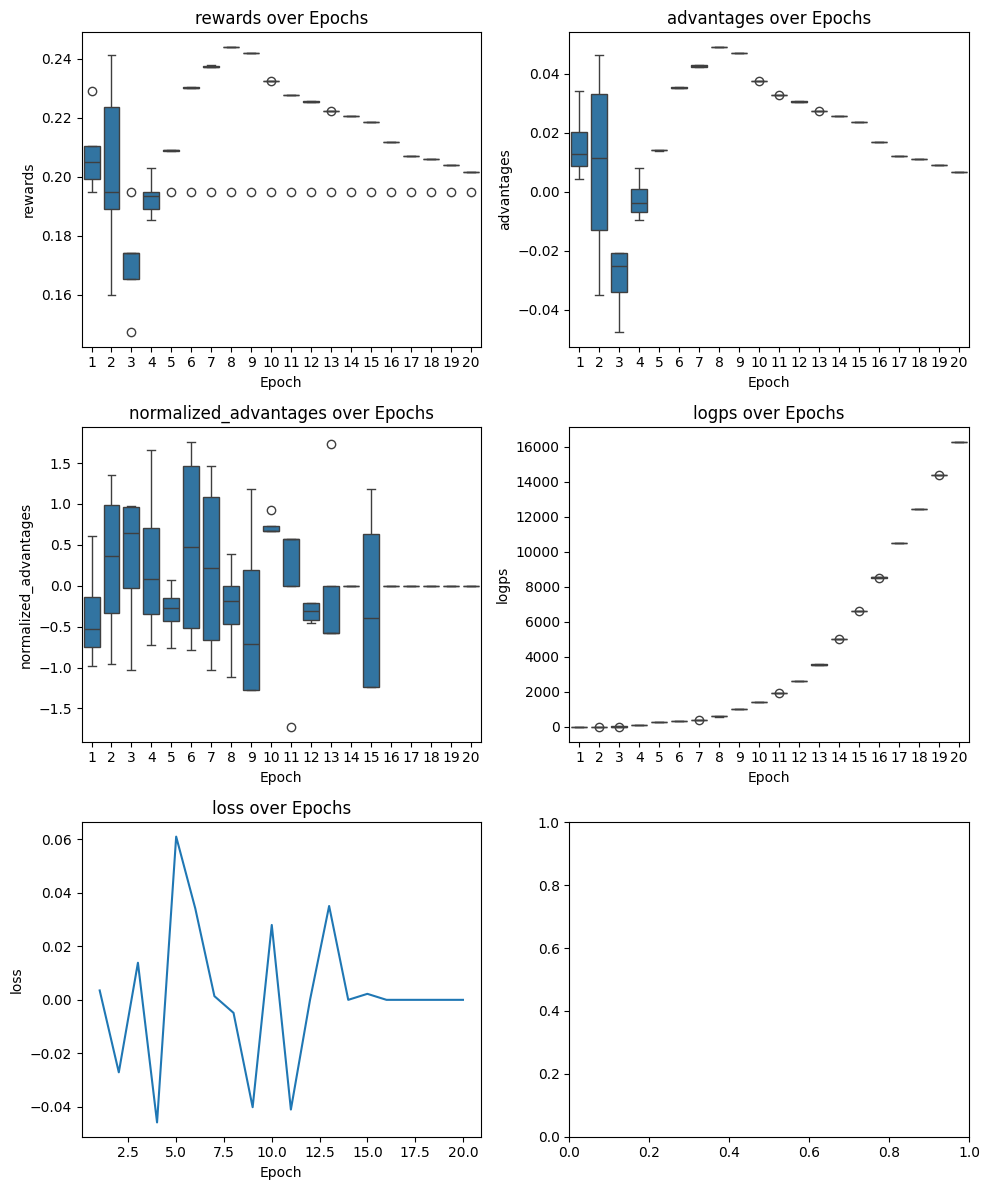

In [122]:
# we have rows with epoch, metric, value. Create a boxplot of value vs epoch for all metrics in a grid
ncols = 2
nrows = math.ceil(n_metrics / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
for i, metric in enumerate(metrics):
    r = i // ncols
    c = i % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    if metric == 'loss':
        sns.lineplot(x='epoch', y='value', data=df[df['metric'] == metric], ax=ax)
    else:
        sns.boxplot(x='epoch', y='value', data=df[df['metric'] == metric], ax=ax)
    ax.set_title('\n'.join(wrap(f'{metric} over Epochs', 40)))
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
plt.tight_layout()
plt.show()

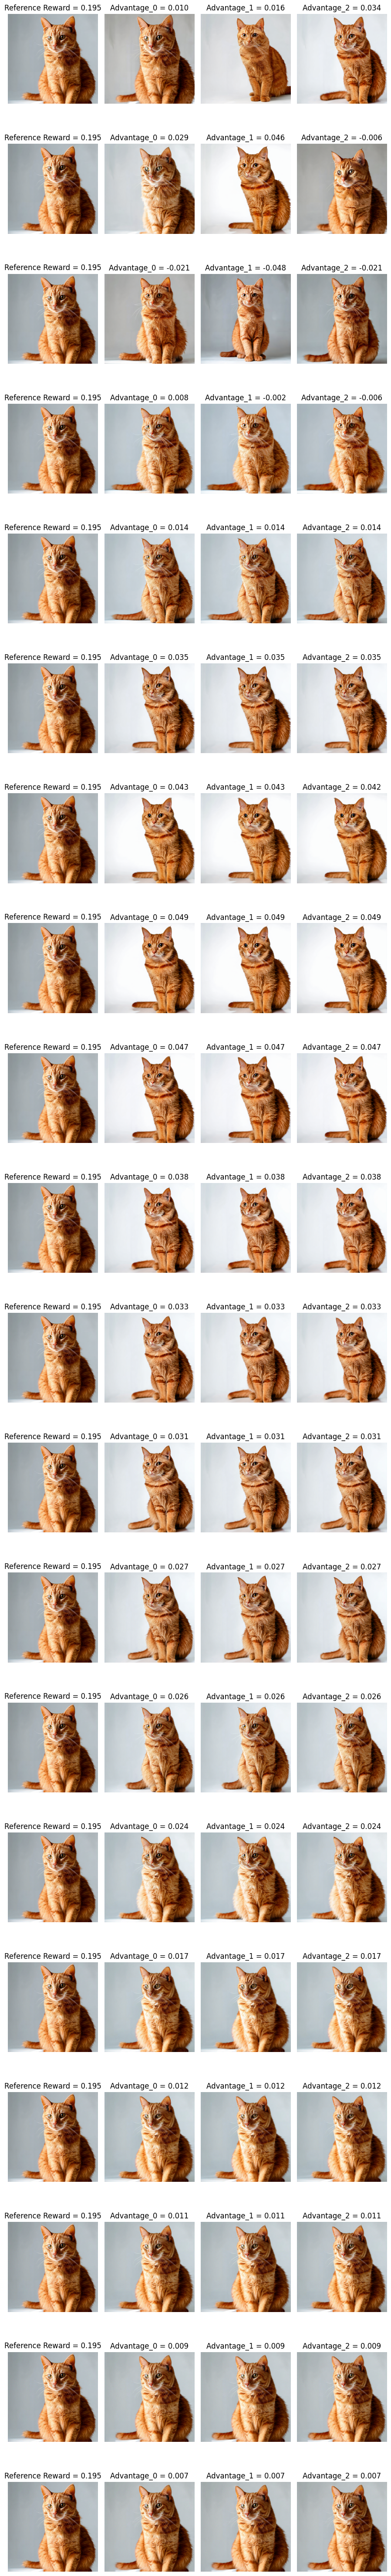

In [123]:
# plot grid of images, epoch rows, G cols. The images are in 'dirname/ep{epoch}_t000_p00_s00_g{G_idx}.png'. For each image, write its reward value from the logs above.
fig, axs = plt.subplots(n_epochs, G+1, figsize=(G*3, n_epochs*3))
for epoch in range(1, n_epochs+1):
    image_paths = [ f'{dirname}/ep{epoch:02d}_t000_p00_s00_ref.png' ] + [ f'{dirname}/ep{epoch:02d}_t000_p00_s00_g{g:02d}.png' for g in range(0, G) ]
    advantages = [ df[(df['epoch'] == epoch) & (df['G_idx'] == g) & (df['metric'] == 'advantages')]['value'].values[0] for g in range(0, G) ]
    ref_reward = df[(df['epoch'] == epoch) & (df['metric'] == 'rewards') & (df['G_idx'].isnull())]['value'].values[0]
    titles = [f'Reference Reward = {ref_reward:.3f}'] + [f'Advantage_{g} = {advantages[g]:.3f}' for g in range(0, G)]
    for g in range(0,G+1):
        ax = axs[epoch-1, g] if n_epochs > 1 else axs[g]
        ax.imshow(plt.imread(image_paths[g]))
        ax.set_title(titles[g])
        ax.axis('off')
plt.tight_layout()
plt.show()